<a href="https://colab.research.google.com/github/Precyors/NLP/blob/main/Deeptech_week_3_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Added this import
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import re
import unicodedata
from bs4 import BeautifulSoup
import contractions
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
import tensorflow_datasets as tfds
# Load train and test splits
(train_data, test_data), info = tfds.load(
    "ag_news_subset",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# Take a peek
print("First 5 records:", df.head())


First 5 records:    Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


In [ ]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
df['Class Index'].value_counts()

,count
Class Index,
3,30000
4,30000
2,30000
1,30000


In [ ]:
# Extract text and labels
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for text, label in train_data:
    train_texts.append(text.numpy().decode("utf-8"))
    train_labels.append(label.numpy())

for text, label in test_data:
    test_texts.append(text.numpy().decode("utf-8"))
    test_labels.append(label.numpy())


In [ ]:
# Text Prerocessing functions

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

def preprocess_texts(texts):
    processed = []
    for doc in texts:
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        processed.append(doc)
    return processed

norm_train_texts = preprocess_texts(train_texts)
norm_test_texts = preprocess_texts(test_texts)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Token and padding
VOCAB_SIZE = 20000
MAX_LENGTH = 200
EMBED_SIZE = 300

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<UNK>")
tokenizer.fit_on_texts(norm_train_texts)
tokenizer.word_index['<PAD>'] = 0

train_sequences = tokenizer.texts_to_sequences(norm_train_texts)
test_sequences = tokenizer.texts_to_sequences(norm_test_texts)

X_train = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:

#Splitting
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

NameError: name 'train_test_split' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential([
    Embedding(VOCAB_SIZE, 300, input_shape=(MAX_LENGTH,)),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(4, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 196, 128)       │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,200,644 (23.65 MB)

 Trainable params: 6,200,644 (23.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_ag_news_cnnn.keras", # Added .keras extension here
    monitor="val_loss",
    save_best_only=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 582s 429ms/step - accuracy: 0.7417 - loss: 0.6462 - val_accuracy: 0.9065 - val_loss: 0.2876
Epoch 2/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 547s 405ms/step - accuracy: 0.9278 - loss: 0.2187 - val_accuracy: 0.9084 - val_loss: 0.2855
Epoch 3/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 547s 405ms/step - accuracy: 0.9499 - loss: 0.1458 - val_accuracy: 0.9027 - val_loss: 0.3179
Epoch 4/20
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 564s 407ms/step - accuracy: 0.9667 - loss: 0.0994 - val_accuracy: 0.9022 - val_loss: 0.3683


In [ ]:
from sklearn.metrics import classification_report

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=["World","Sports","Business","Sci/Tech"]))

238/238 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9019 - loss: 0.2970
Test Accuracy: 0.9030
238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.96      0.96      0.96      1900
    Business       0.87      0.86      0.86      1900
    Sci/Tech       0.86      0.90      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



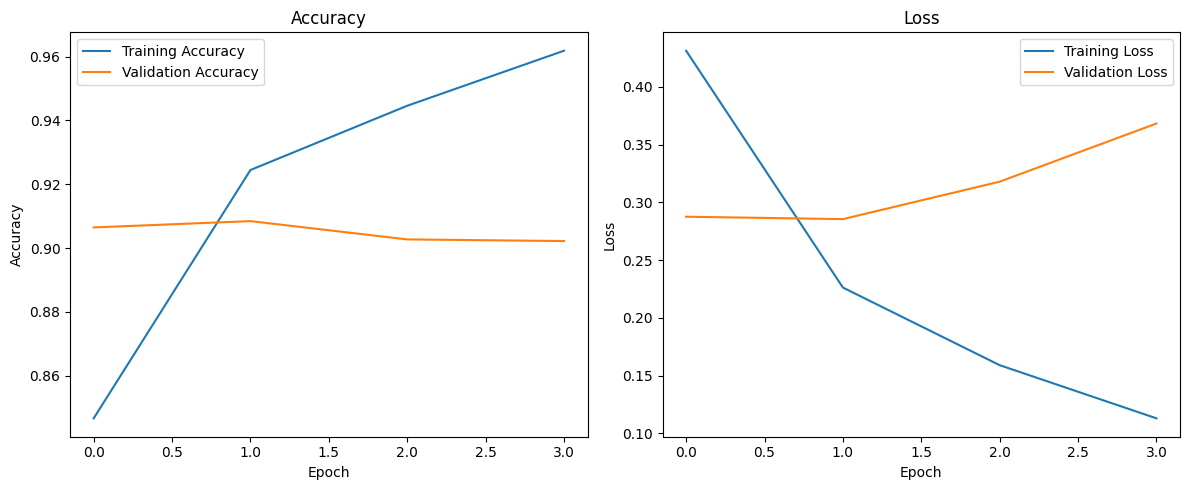

In [ ]:
# Plot training and validation curve
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

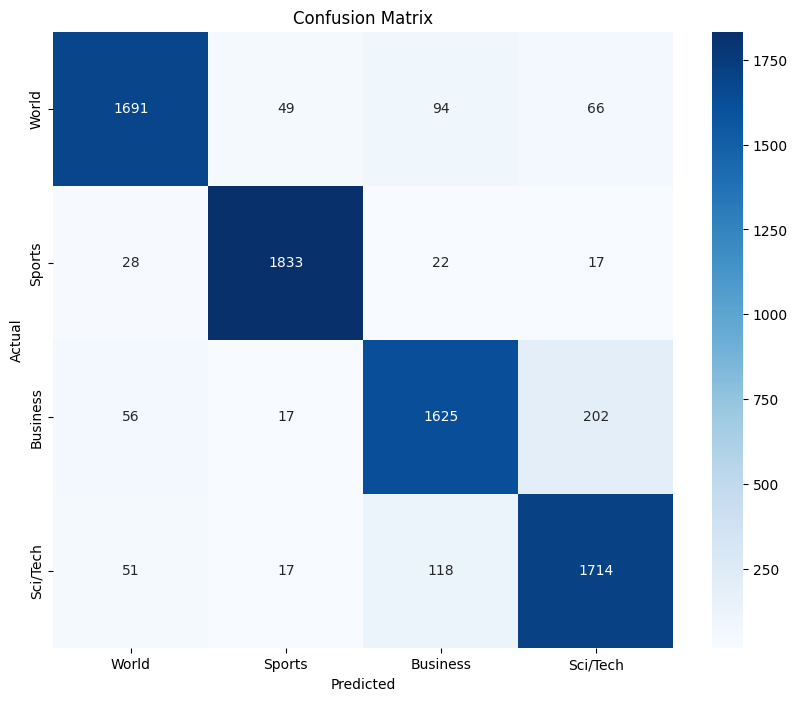

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['World', 'Sports', 'Business', 'Sci/Tech']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('my_confusion_matrix.png')

In [ ]:
# single text prediction helper
def preprocess_single_text(text):
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = text.lower()
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(' +', ' ', text).strip()
    return text

def predict_text(text):
    norm_text = preprocess_single_text(text)
    seq = tokenizer.texts_to_sequences([norm_text])
    padded = pad_sequences(seq, maxlen=MAX_LENGTH)
    prob = model.predict(padded)[0]
    class_idx = np.argmax(prob)
    classes = ["World","Sports","Business","Sci/Tech"]
    return classes[class_idx], prob[class_idx]

# Example usage
new_text = "The company deal with invoices"
label, probability = predict_text(new_text)
print(f"Predicted class: {label}, Probability: {probability:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: Business, Probability: 0.52


In [ ]:
from tensorflow.keras.models import load_model
import pickle

model = load_model("best_ag_news_cnnn.keras")

with open("tokkenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("labbels.pkl", "rb") as f:
    classes = pickle.load(f)

#classes = ["World", "Sports", "Business", "Sci/Tech"]

# with open("labbels.pkl", "wb") as f:
    # pickle.dump(classes, f)